# Using Textract for Asynchronous Processing

---

## Introduction
Amazon Textract is a machine learning (ML) service that automatically extracts text, handwriting, and data from scanned documents. It goes beyond simple optical character recognition (OCR) to identify, understand, and extract data from forms and tables. This notebook demonstrates how to programatically use Amazon Textract to solve common intelligent document processing challenges such as: detecting text within a document, analyzing a document for relationships between detected items, using asynchronous operations for batch processing, analyzing a document for financially-related relationships between text, and more.

</p>

- 1. [Prerequisites](#section_1_0)
    - 1.1 [Install packages](#section_1_1)
    - 1.2 [Import packages and modules](#section_1_2)
    - 1.3 [Setup the notebook role and session](#section_1_3)
    - 1.4 [Setup the AWS service clients](#section_1_4)
    - 1.5 [Upload resource files](#section_1_5)    
- 2. [An Introduction to Document Processing with Amazon Textract](#section_2_0)
    - 2.1 [Sample document for text detection](#section_2_1)
    - 2.2 [Detecting document text](#section_2_2)
    - 2.3 [Amazon Textract Response Objects](#section_2_3)
    - 2.4 [Visualizing the Response Objects Hierarchy](#section_2_4)
- 3. [Asynchronous processing](#section_3_0)
    - 3.1 [Sample document for asynchronous processing](#section_3_1)
    - 3.2 [Asynchronous Document Analysis](#section_3_2)
    - 3.3 [Asynchronous process workflow](#section_3_3)
- 4. [Expense Document Analysis](#section_4_0)
    - 4.1 [Sample document for expense document analysis processing](#section_4_1)
    - 4.2 [Execute a synchronous analyze expense job](#section_4_2)
- 5. [Processing Identity Documents](#section_5_0)
    - 5.1 [Sample document for identity document analysis processing](#section_5_1)
    - 5.2 [Execute a synchronous analyze identity process](#section_5_2)
    - 5.3 [Sample identity document for document analysis queries](#section_5_3)
    - 5.4 [Processing a U.S. Social Security Card with Queries](#section_5_4)    
- 6. [Document Enrichment using Redaction (Optional)](#section_6_0)
- 7. Additional Resources

##### **Let's get started!**

---

## 1. Prerequisites
<a id=section_1_0></a>

In this section, we'll install and import packages, establish the notebook execution role and session, and setup the AWS service clients.

### 1.1 Install packages
<a id=section_1_1></a>

We use *pip* to install packages from the Python Package Index and other indexes. A package contains all the files you need for a module.
Modules are Python code libraries you can include in your project. You can think of Python packages as the directories on a file system and modules as files within directories.

**Note:** after executing code in this cell there will be lots of debug output, this is normal, and expected.

In [ ]:
!pip install amazon-textract-caller
!pip install amazon-textract-prettyprinter
!pip install amazon-textract-response-parser
!pip install boto3
!pip install botocore
!pip install s3fs
!pip install textract-trp

  Using cached amazon_textract_response_parser-0.1.48-py2.py3-none-any.whl.metadata (11 kB)
Using cached amazon_textract_response_parser-0.1.48-py2.py3-none-any.whl (29 kB)
  Attempting uninstall: amazon-textract-response-parser
    Found existing installation: amazon-textract-response-parser 1.0.3
    Uninstalling amazon-textract-response-parser-1.0.3:
      Successfully uninstalled amazon-textract-response-parser-1.0.3


### 1.2 Import packages and modules
<a id=section_1_2></a>

Python code in one module gains access to the code in another module by the process of importing it. In this section, we import packages and modules needed to execute code cells in this notebook.

In [ ]:
import sagemaker
import boto3
import s3fs
import time
import json
import io
import os
from io import BytesIO

from PIL import Image, ImageDraw, ImageOps

from trp import Document
import urllib.request

from textractcaller import call_textract_analyzeid
import trp.trp2_analyzeid as t2id

from tabulate import tabulate
import trp.trp2 as t2

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/base_serializers.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  import scipy.sparse


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 1.3 Setup the notebook role and session
<a id=section_1_3></a>

As a managed service, Amazon SageMaker performs operations on your behalf on the AWS hardware that is managed by SageMaker. SageMaker can perform only operations that the user permits. A SageMaker user can grant these permissions with an IAM role (referred to as an execution role).

To create and use a locally available execution role, execute the code in the following cell

In [ ]:
# Get the IAM role and Sagemaker session
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

# Get the SakeMaker session
session = sagemaker.Session()

# Get the region name
region = session.boto_region_name

print('Using IAM role arn: {}'.format(role))
print('Using region: {}'.format(region))

Using IAM role arn: arn:aws:iam::842675974990:role/service-role/AmazonSageMaker-ExecutionRole-20240919T022017
Using region: us-east-1


### 1.4 Setup the AWS service clients
<a id=section_1_4></a>

AWS' Boto3 library is used commonly to integrate Python applications with various AWS services. Clients provide a low-level interface to the AWS service. In this section, we will create two Boto3 clients: s3 and textract, to help execute code cells in this notebook.

In [ ]:
# Setup the S3 client
s3_client = boto3.client('s3')

# Setup the Textract client
textract_client = boto3.client('textract', region_name=region)

# Get bucket settings
s3_bucket = session.default_bucket()
s3_bucket_prefix = 'sample-files'
s3_file_path = 's3://{}/{}'.format(s3_bucket, s3_bucket_prefix)

# The path to our files in the S3 bucket
print('S3 FILE PATH: {}'.format(s3_file_path))

S3 FILE PATH: s3://sagemaker-us-east-1-842675974990/sample-files


### 1.5 Upload resource files
<a id=section_1_5></a>

In this cell, we'll use the high-level S3 AWS CLI to upload our resource files to the default S3 bucket

In [ ]:
cmd = 'aws s3 cp {} {} --recursive'.format('./sample-files', s3_file_path)
os.system(cmd)

#!aws s3 cp ./aim204/sample-files <Paste the S3 FILE PATH here> --recursive

upload: sample-files/.gitkeep to s3://sagemaker-us-east-1-842675974990/sample-files/.gitkeep
upload: sample-files/OneLine.png to s3://sagemaker-us-east-1-842675974990/sample-files/OneLine.png
upload: sample-files/SSN_John_Doe.jpg to s3://sagemaker-us-east-1-842675974990/sample-files/SSN_John_Doe.jpg
upload: sample-files/Benefit_Application_Form_John_Doe.pdf to s3://sagemaker-us-east-1-842675974990/sample-files/Benefit_Application_Form_John_Doe.pdf
upload: sample-files/hello-world-image.png to s3://sagemaker-us-east-1-842675974990/sample-files/hello-world-image.png
upload: sample-files/Utility_Bill_John_Doe.png to s3://sagemaker-us-east-1-842675974990/sample-files/Utility_Bill_John_Doe.png
upload: sample-files/Benefit_Application_Form_John_Doe.png to s3://sagemaker-us-east-1-842675974990/sample-files/Benefit_Application_Form_John_Doe.png
upload: sample-files/comprehend_train_data.csv to s3://sagemaker-us-east-1-842675974990/sample-files/comprehend_train_data.csv
upload: sample-files/fic

0

## 2. An Introduction to Document Processing with Amazon Textract
<a id=section_2_0></a>

In this section, we'll demonstrate how to programatically use the Amazon Textract SDK to handle processing common document types.

### 2.1 Sample document for text detection
<a id=section_2_1></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to detect the document's text

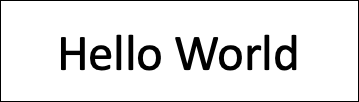

In [ ]:
# A sample PNG image file that contains a single line of text
file_name = "hello-world-image.png"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.expand(Image.open(f),border=1,fill='black'))

### 2.2 Detecting document text
<a id=section_2_2></a>

In this code cell, we'll be calling Textract to synchronously process a PNG image document containing a single line of text. This is a simple example to help us become familiar with the Amazon Textract request and response syntax. You can consider this example the 'Hello World' of progamatically leveraging Amazon Textract.

In [ ]:
# Call Amazon Textract
detect_text_response = textract_client.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3_bucket,
            'Name': object_key
        }
    }
)

# Display the single line of text in the PNG file detected by Textract
for item in detect_text_response["Blocks"]:
    if item["BlockType"] == "LINE":
        print('The line of text detected by Amazon Textract from our sample PNG image file is, you guessed it: {}\n'.format(item["Text"]))

The line of text detected by Amazon Textract from our sample PNG image file is, you guessed it: Hello World



### 2.3 Amazon Textract Response Objects
<a id=section_2_3></a>

Before we dive deeper into the lab, let's take a minute or two to better understand Amazon Textract Response Objects.

Amazon Textract **operations return different types of objects depending on the operations run**.

- For **detecting text and analyzing a generic document**, the operation **returns a Block object**.
- For **analyzing an invoice or receipt**, the operation **returns an ExpenseDocuments object**.
- For **analyzing identity documentation**, the operation **returns an IdentityDocumentFields object**.

In [ ]:
# Let's inspect the Amazon Textract Response Objects for detecting text (returned from the previous cell)

print('The Amazon Textract Response Objects for invoking detect_document_text:\n')
print(json.dumps(detect_text_response, indent=4))

The Amazon Textract Response Objects for invoking detect_document_text:

{
    "DocumentMetadata": {
        "Pages": 1
    },
    "Blocks": [
        {
            "BlockType": "PAGE",
            "Geometry": {
                "BoundingBox": {
                    "Width": 1.0,
                    "Height": 1.0,
                    "Left": 0.0,
                    "Top": 0.0
                },
                "Polygon": [
                    {
                        "X": 0.0,
                        "Y": 0.0
                    },
                    {
                        "X": 1.0,
                        "Y": 0.0
                    },
                    {
                        "X": 1.0,
                        "Y": 1.0
                    },
                    {
                        "X": 0.0,
                        "Y": 1.0
                    }
                ]
            },
            "Id": "2d9c9f66-4eda-4315-b421-b9a422c33bc7",
            "Relationships": [
     

### 2.4 Visualizing the Response Objects Hierarchy
<a id=section_2_4></a>

To help us visualize the hierachy of the Amazon Textract response objects for detecting text, here's an illustration of a portion of the JSON response object hierarchy

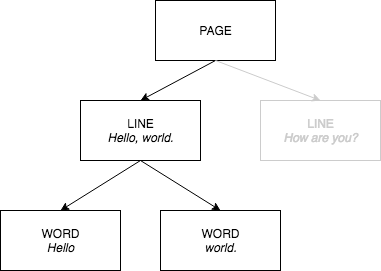

In [ ]:
urllib.request.urlretrieve(
  'https://docs.aws.amazon.com/images/textract/latest/dg/images/hieroglyph-text-detection.png', 'textract-pages-lines-words.png')
img = Image.open("textract-pages-lines-words.png")
display(img)

In our example, the Amazon Textract Response contains one **PAGE** BlockType, which contains one child **LINE** BlockType, which contains two children **WORD** BlockTypes.

Additionally, the **LINE** BlockType contains the value **'Amazon Textract'** and also has two child **WORD** BlockTypes which are: **Amazon** and **Textract**

Referencing the **Ids** list object within the **Relationships** list object is helpful for understanding the hierarchical relationships between Amazon Textract Response objects. We've included some additional resources at the end of this notebook for further reading on this topic.

Lastly, **Confidence** scores are numeric values ranging between 0 and 100 that indicate the probability that a given prediction is correct, where highly confident scores will be closer to 100.

## 3. Asynchronous processing
<a id=section_3_0></a>

In this section, we'll introduce the concept of Textract Asynchronous Operations, which queue incoming requests and processes them asynchronously. By using asynchronous jobs, documents can be processed without blocking computing resources.

Amazon Textract provides an asynchronous API that you can use to process **multipage** documents in **PDF or TIFF** format. You can also use asynchronous operations to process **single-page** documents that are in **JPEG, PNG, TIFF, or PDF** format.

### 3.1 Sample document for asynchronous processing
<a id=section_3_1></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to detect document's text

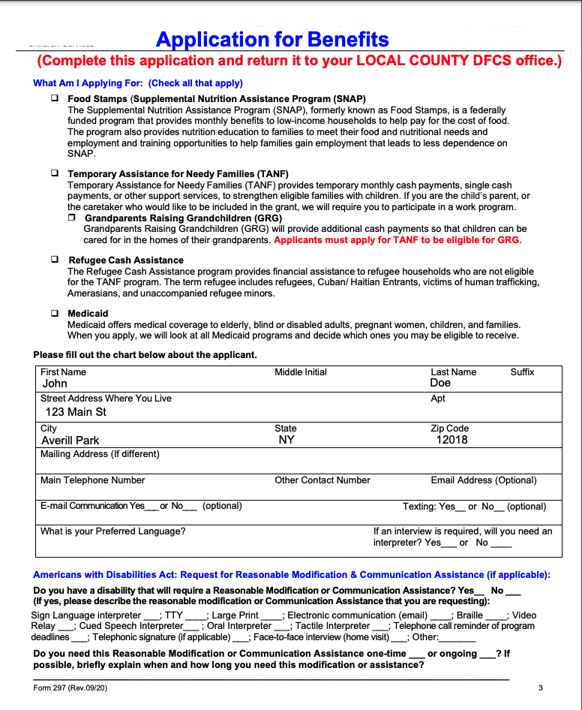

In [ ]:
# Sample document
file_name = "Benefit_Application_Form_John_Doe.png"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.scale(Image.open(f),0.75))

### 3.2 Asynchronous Document Analysis
<a id=section_3_2></a>

In this section we'll start a document analysis job that will analyze a sample benefits application form to find relationships between detected items. The document analysis job will return a job identifier (JobId) as a reference to the job.

We'll also create three helper functions for asynchronously processing a Textract Document Analysis Job.

1. **start_analyze_job**: responsible for initiating the asynchronous document analysis job of a benefit application form document
2. **is_job_complete**: periodically checks for job status completion (i.e. no longer IN_PROGRESS)
3. **get_job_results**: gets the results from the Amazon Textract asynchronous job we executed


In [ ]:
def start_analyze_job(s3_bucket, key_name):
    response = None
    response = textract_client.start_document_analysis(
        DocumentLocation={
            'S3Object': {
                'Bucket': s3_bucket,
                'Name': key_name
            }
        },
        FeatureTypes=['FORMS'],
        OutputConfig={
            'S3Bucket': s3_bucket,
            'S3Prefix': 'textract-output/benefit-app'
        }
    )

    return response["JobId"]

def is_job_complete(jobId):
    response = textract_client.get_document_analysis(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(5)
        response = textract_client.get_document_analysis(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def get_job_results(jobId):
    pages = []
    response = textract_client.get_document_analysis(JobId=jobId)
    pages.append(response)
    print("Result page recieved: {}".format(len(pages)))
    nextToken = None
    if('NextToken' in response):
        nextToken = response['NextToken']

    while(nextToken):
        response = textract_client.get_document_analysis(JobId=jobId, NextToken=nextToken)

        pages.append(response)
        print("Result page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            nextToken = response['NextToken']

    return pages

In [ ]:
# Sample document
file_name = "Benefit_Application_Form_John_Doe.pdf"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Start the asynchronous processing job
job_id = start_analyze_job(s3_bucket, object_key)

# Print the JobId and the input document location
print("Started an asynchronous Analyze Document Job with job_id: {}".format(job_id))
print("Input document URI: {}\n".format(object_key))

# Invoke our helper functions to check the job status and get the results
if(is_job_complete(job_id)):
    benefit_application_response = get_job_results(job_id)

# Use the Textract Response Parser library to easily parser JSON returned by Amazon Textract
doc = Document(benefit_application_response)

# Display the key/value pairs detected by the Analyze Document Job
print("Result Fields:")

for field in doc.pages[0].form.fields:
    print("Key: {}, Value: {}".format(field.key, field.value))

Started an asynchronous Analyze Document Job with job_id: fa6b477fc98bb9970421c018c003bded51553689f240df759bb011b0f89ed46d
Input document URI: sample-files/Benefit_Application_Form_John_Doe.pdf

Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
Result page recieved: 1
Result Fields:
Key: Refugee Cash Assistance, Value: NOT_SELECTED
Key: Temporary Assistance for Needy Families (TANF), Value: NOT_SELECTED
Key: Food Stamps (Supplemental Nutrition Assistance Program (SNAP), Value: NOT_SELECTED
Key: Medicaid, Value: NOT_SELECTED
Key: Last Name, Value: Doe
Key: Other:, Value: NOT_SELECTED
Key: No, Value: NOT_SELECTED
Key: deadlines, Value: NOT_SELECTED
Key: Yes, Value: NOT_SELECTED
Key: Sign Language interpreter, Value: NOT_SELECTED
Key: Main Telephone Number, Value: None
Key: State, Value: NY
Key: First Name, Value: John
Key: Yes, Value: NOT_SELECTED
Key: What is your Preferred Language?, Value: None
Key: No, Value: NOT_SELECTED
Key: Telephonic signature (if applicable),

### 3.3 Asynchronous process workflow
<a id=section_3_3></a>

Now that we've completed an example job, let's briefly a look at the asynchronous process flow diagram to understand how the job was executed.

1. First, we start the aschronous analyze text job by calling the StartDocumentAnalysis method (via our start_analyze_job() helper function), which returns a JobId for reference.
2. Next, we attempt to get the job results - using the JobId - by calling the get_document_analysis function (via our is_job_complete() helper function). We repeat this call every 5 seconds until the job status in no longer IN_PROGRESS.
3. Once the job status is no longer IN_PROGRESS, we again attempt to get the job results - using the JobId - by calling the get_document_analysis function, this time via our get_job_results() helper function).
4. Finally, we use the Textract Response Parser library to parse the JSON returned by Amazon Textract and display the results.

Note: We don't recommend getting the request completion status by repeatedly calling the Amazon Textract Get operation. This is because Amazon Textract throttles the Get operation if too many requests are made. If you're processing multiple documents at the same time, it's simpler and more efficient to monitor one SQS queue for the completion notification than to poll Amazon Textract for the status of each job individually. [More details here](https://docs.aws.amazon.com/textract/latest/dg/api-async.html)


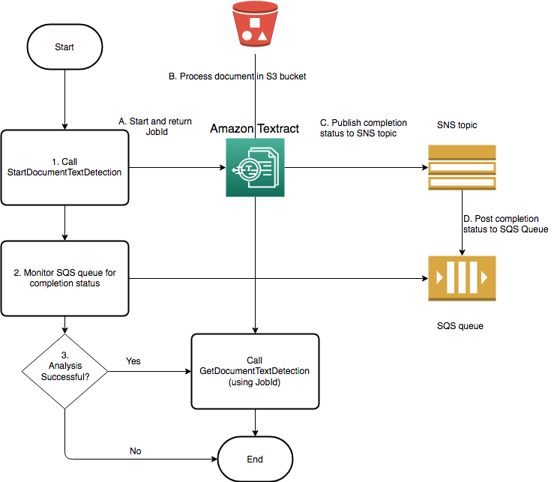

In [ ]:
urllib.request.urlretrieve(
  'https://docs.aws.amazon.com/images/textract/latest/dg/images/asynchronous.png', 'textract-asynchronous-process-flow.png')
img = Image.open('textract-asynchronous-process-flow.png')
display(ImageOps.scale(img,0.75))

## 4.0 Expense Document Analysis
<a id=section_4_0></a>

In this section, we will initiate a synchronous expense analysis job, which is designed to detect items in invoices or receipts for data like contact information, items purchased, and vendor names.

### 4.1 Sample document for expense document analysis processing
<a id=section_4_1></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to perform expense document analysis

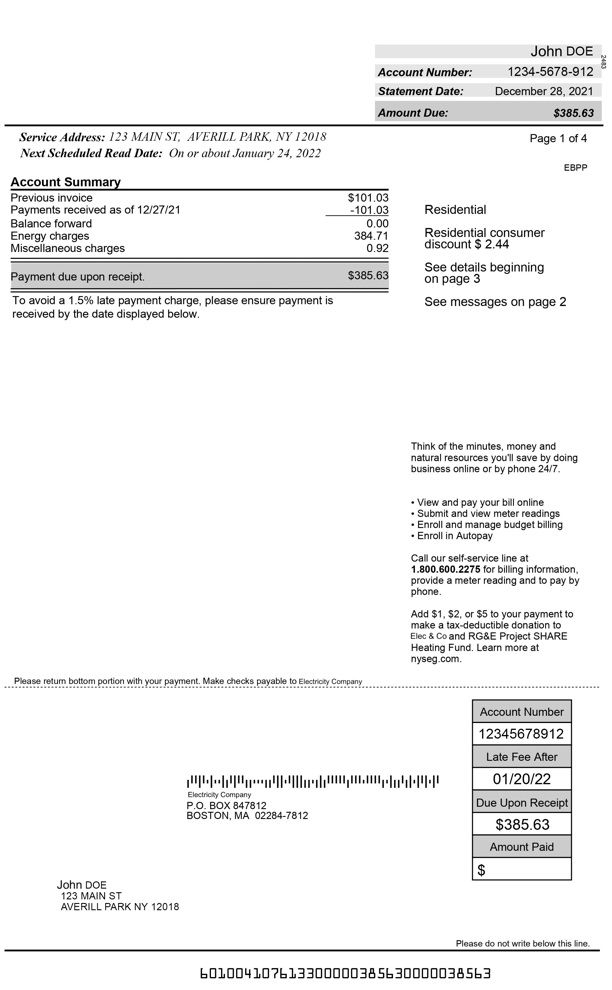

In [ ]:
# Sample document
file_name = "Utility_Bill_John_Doe.png"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.scale(Image.open(f),0.30))

### 4.2 Execute a synchronous analyze expense job
<a id=section_4_2></a>

Running the cells below will execute the analyze expense job and display detected labels and values for LineItemExpenseFields and SummaryFields

We've created two helper functions to help with parsing and printing:
1. **print_labels_and_values**: displays values if labels are detected and returned
2. **process_expense_analysis**: displays LineItemExpenseFields and SummaryFields, along with their corresponding confidence score.

Observe that some fields with lower confidence scores may be affected by smaller font size.

In [ ]:
def print_labels_and_values(field):

    # Only if labels are detected and returned
    if "LabelDetection" in field and "ValueDetection" in field:
        print(
            "Label Detection - Confidence: {}".format(
                str(field.get("LabelDetection")["Confidence"])
            )
            + ", "
            + "Summary Values: {}".format(str(field.get("LabelDetection")["Text"]))
            + "\n"
            + "Value Detection - Confidence: {}".format(
                str(field.get("ValueDetection")["Confidence"])
            )
            + ", "
            + "Summary Values: {}".format(str(field.get("ValueDetection")["Text"]))
            + "\n"
        )

def process_expense_analysis(bucket, document, region):

    # process using S3 object
    response = textract_client.analyze_expense(
        Document={'S3Object': {'Bucket': bucket, 'Name': document}}
    )

    for expense_doc in response["ExpenseDocuments"]:
        for line_item_group in expense_doc["LineItemGroups"]:
            for line_items in line_item_group["LineItems"]:
                for expense_fields in line_items["LineItemExpenseFields"]:
                    print_labels_and_values(expense_fields)

        print("Summary:")
        for summary_field in expense_doc["SummaryFields"]:
            print_labels_and_values(summary_field)

In [ ]:
# Execute the job
process_expense_analysis(s3_bucket, object_key, region)

Summary:
Label Detection - Confidence: 99.52626037597656, Summary Values: Service Address:
Value Detection - Confidence: 95.42467498779297, Summary Values: 123 MAIN ST, AVERILL PARK, NY 12018

Label Detection - Confidence: 99.7367935180664, Summary Values: Account Number:
Value Detection - Confidence: 99.73869323730469, Summary Values: 1234-5678-912

Label Detection - Confidence: 99.76708984375, Summary Values: Account Number
Value Detection - Confidence: 99.78903198242188, Summary Values: 12345678912

Label Detection - Confidence: 97.76214599609375, Summary Values: Payments received as of 12/27/21
Value Detection - Confidence: 97.6619644165039, Summary Values: -101.03

Label Detection - Confidence: 71.73700714111328, Summary Values: Amount Paid
Value Detection - Confidence: 71.68267059326172, Summary Values: $

Label Detection - Confidence: 99.81846618652344, Summary Values: Statement Date:
Value Detection - Confidence: 99.46724700927734, Summary Values: December 28, 2021

Label Detec

## 5.0 Processing Identity Documents
<a id=section_5_0></a>

In the next two sections, we'll demonstate how to process two common types of identity documents issued by the US Government: a U.S. Driver's License and a U.S. Social Security Card.
We'll first process a US Driver's license using the Amazon Textract AnalyzeID API. Next, we'll use a feature of the Amazon Textract AnalyzeDocument API called Queries, which allow customers to ask about information within the document using natural language. For example, What is SSN number?

### 5.1 Sample document for identity document analysis processing
<a id=section_5_1></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to perform identity document analysis

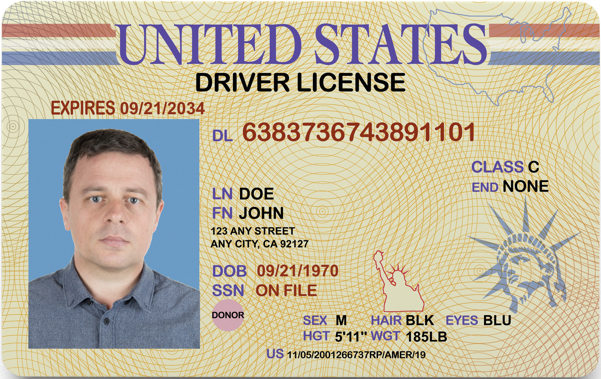

In [ ]:
# Sample document
file_name = "drivers-license.png"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.scale(Image.open(f),0.30))

### 5.2 Execute a synchronous analyze identity process
<a id=section_5_2></a>

In this code cell, we also use [Amazon Textract Caller tools](https://pypi.org/project/amazon-textract-caller/), which provide a collection of ready to use functions and sample implementations to speed up the evaluation and development for any project using Amazon Textract.

The AnalyzeID API returns information in a structure called IdentityDocumentFields, which contains the normalized keys and their corresponding value.
For example, the FIRST_NAME key corresponds to the value of John

In [ ]:
# Using Amazon Textract Caller tools to call Textract AnalyzeId
response_drivers_license = call_textract_analyzeid(document_pages=[f's3://{s3_bucket}/{object_key}'])

# Here we iterate of the collection IdentityDocuments and IdentityDocumentFields
for id_docs in response_drivers_license['IdentityDocuments']:
    id_doc_kvs={}
    for field in id_docs['IdentityDocumentFields']:
        if field['ValueDetection']['Text']:
            id_doc_kvs[field['Type']['Text']] = field['ValueDetection']['Text']

# Display the key/value pairs detected by Textract
print(json.dumps(id_doc_kvs, indent=4))

{
    "FIRST_NAME": "JOHN",
    "LAST_NAME": "DOE",
    "CITY_IN_ADDRESS": "ANY CITY",
    "ZIP_CODE_IN_ADDRESS": "92127",
    "STATE_IN_ADDRESS": "CA",
    "STATE_NAME": "UNITED STATES OF STATE",
    "DOCUMENT_NUMBER": "6383736743891101",
    "EXPIRATION_DATE": "09/21/2034",
    "DATE_OF_BIRTH": "09/21/1970",
    "ID_TYPE": "DRIVER LICENSE FRONT",
    "ENDORSEMENTS": "NONE",
    "CLASS": "C",
    "ADDRESS": "123 ANY STREET"
}


### 5.3 Sample identity document for document analysis queries
<a id=section_5_3></a>

Let's have a look at the sample input document we'll use as input for Amazon Textract to perform a document analysis using queries.

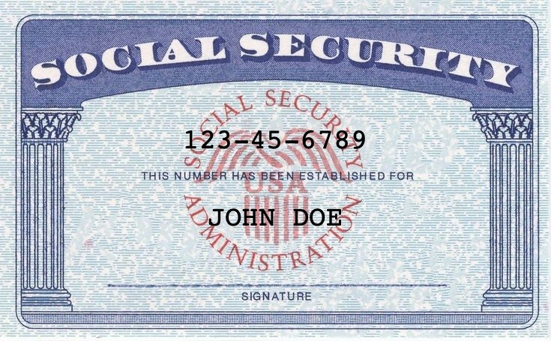

In [ ]:
# Sample document
file_name = "SSN_John_Doe.jpg"

# The location of the sample PNG image file in your Amazon S3 bucket.
object_key = '{}/{}'.format(s3_bucket_prefix, file_name)

# Display the PNG image
fs = s3fs.S3FileSystem()
with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
    display(ImageOps.scale(Image.open(f),0.75))

### 5.4 Processing a U.S. Social Security Card with Queries
<a id=section_5_4></a>

In the following cell observe that, in the asynchronous start_analyze_job() function, there are two queries in the JSON request: **"What is SSN number?"** and **"What is the name on SSN?"**. Each query contains the question you want to ask in the **Text** attribute and the **Alias** attribute you want to associate with the question, returned in the JSON response. The aliases to the aforementioned questions are **"SSN_NUMBER"** and **"SSN_OWNER_NAME"**, respectively. Additionally, there are two helper functions to help with monitoring the analyze document job status and displaying the query results.

In [ ]:
def start_analyze_job(s3_bucket, key_name):
    response = None
    response = textract_client.start_document_analysis(
        DocumentLocation={
            'S3Object': {
                'Bucket': s3_bucket,
                'Name': key_name
            }
        },
        FeatureTypes=['QUERIES'],
        QueriesConfig={
            "Queries": [
            {
                "Text": "What is SSN number?",
                "Alias": "SSN_NUMBER"
            },
            {
                "Text": "What is the name on SSN?",
                "Alias": "SSN_OWNER_NAME"
            }
          ]},
        OutputConfig={
            'S3Bucket': s3_bucket,
            'S3Prefix': 'textract-output/ssn'
        }
    )

    return response["JobId"]

def is_job_complete(jobId):
    response = textract_client.get_document_analysis(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(5)
        response = textract_client.get_document_analysis(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def print_result_in_document(response):
    doc = t2.TDocumentSchema().load(response[0])
    page = doc.pages[0]
    doc_query_answers = doc.get_query_answers(page=page)
    print(tabulate(doc_query_answers, tablefmt="github"))

In [ ]:
# Main code for execution
# -----
job_id = start_analyze_job(s3_bucket, object_key)

# Monitor the job status
print("Started analyze job with id: {}, document is: {}".format(job_id, object_key))
if(is_job_complete(job_id)):
    ssn_response = get_job_results(job_id)

# Print the result
print_result_in_document(ssn_response)

Started analyze job with id: 3055dd176d0a4676e837fd2f5ab716bc9b4c8b102379df2e2b9a601869e6bf21, document is: sample-files/SSN_John_Doe.jpg
Job status: IN_PROGRESS
Job status: SUCCEEDED
Result page recieved: 1
|--------------------------|----------------|-------------|
| What is the name on SSN? | SSN_OWNER_NAME | JOHN DOE    |
| What is SSN number?      | SSN_NUMBER     | 123-45-6789 |


## 6. Document Enrichment using Redaction
<a id=section_6_0></a>

Redacting personally identifiable information within documents is important to avoid identity theft. Redaction is a form of document enrichment used to conceal or remove confidential information.
In this code cell, we demonstrate how to use the Geometry data type within the JSON response object to draw a solid black rectangle over the social security number on the SSN card.

We'll resuse the job results from the previous section since we just need to parse the JSON response and check if any of the query results (i.e. the answers to our questions) contain a digit -- if so, then we get the geometric coordinates of the query result and draw a solid black rectangle.

In [ ]:
def ssn_redaction(response, s3_bucket, object_key):

    fs = s3fs.S3FileSystem()
    with fs.open('{}/{}'.format(s3_bucket, object_key)) as f:
        img = Image.open(f)
        width, height = img.size

        # Add redaction to SSN
        for item in response[0]["Blocks"]:
            if item["BlockType"] == "QUERY_RESULT":
                result = any([char.isdigit() for char in item["Text"]])
                if(result):
                    x1 = item["Geometry"]["BoundingBox"]["Left"]*width
                    y1 = item["Geometry"]["BoundingBox"]["Top"]*height-2
                    x2 = x1 + (item["Geometry"]["BoundingBox"]["Width"]*width)+5
                    y2 = y1 + (item["Geometry"]["BoundingBox"]["Height"]*height)+2

                    draw = ImageDraw.Draw(img)
                    draw.rectangle([x1, y1, x2, y2], fill="Black")
                    display(img)

Result page recieved: 1


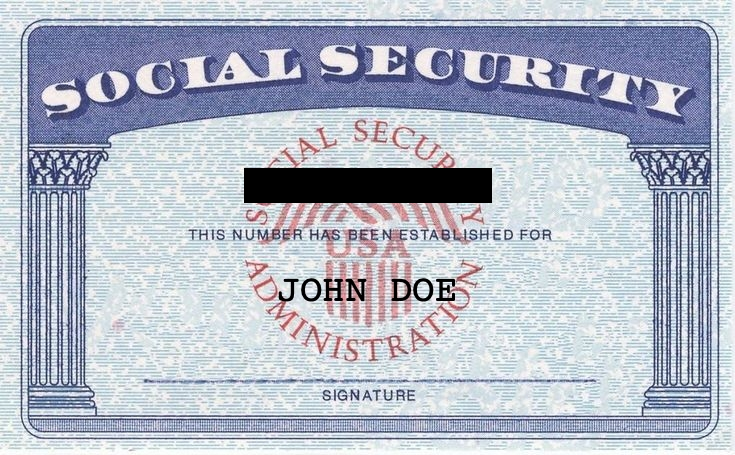

In [ ]:
# Main code for execution
# -----

# Let's reuse the job_id from the previous section
response = get_job_results(job_id)

# Redact the SSN
ssn_redaction(response, s3_bucket, object_key)

## 7. Additional Resources
<a id=section_8_0></a>

- https://docs.aws.amazon.com/textract/latest/dg/API_BoundingBox.html
- https://docs.aws.amazon.com/textract/latest/dg/text-location.html
- https://docs.aws.amazon.com/textract/latest/dg/how-it-works-lines-words.html
- https://aws.amazon.com/solutions/guidance/intelligent-document-processing-on-aws/

# Assignment Question #8

In pseudo-code, briefly note the steps that needed for asynchronous document processing.


(add your answer in the markdown cell that follows)

- Set up the Textract client using Boto3 to interact with Amazon Textract.

textract_client = boto3.client('textract', region_name='your-region')

- Use the start_document_analysis method to initiate an asynchronous job. Specify the S3 location of the document and any required analysis features, such as FORMS, TABLES, or QUERIES.

def start_analyze_job(s3_bucket, key_name):
    response = textract_client.start_document_analysis(
        DocumentLocation={
            'S3Object': {
                'Bucket': s3_bucket,
                'Name': key_name
            }
        },
        FeatureTypes=['FORMS', 'TABLES'],  # or other features as needed
        OutputConfig={
            'S3Bucket': s3_bucket,
            'S3Prefix': 'output-folder'
        }
    )
    return response["JobId"]
    
- Periodically check the job status using the get_document_analysis method until the job status changes from "IN_PROGRESS" to either "SUCCEEDED" or "FAILED."

def is_job_complete(job_id):
    while True:
        response = textract_client.get_document_analysis(JobId=job_id)
        status = response["JobStatus"]
        print(f"Job status: {status}")
        if status == "SUCCEEDED" or status == "FAILED":
            break
        time.sleep(5)
    return status
    
- Once the job is complete, retrieve the results using the get_document_analysis method. Handle paginated responses if the results span multiple pages.

def get_job_results(job_id):
    results = []
    next_token = None
    while True:
        response = textract_client.get_document_analysis(JobId=job_id, NextToken=next_token) if next_token else textract_client.get_document_analysis(JobId=job_id)
        results.append(response)
        next_token = response.get('NextToken', None)
        if not next_token:
            break
    return results
    
- Use the Textract Response Parser or other methods to parse the JSON response and extract the required information, such as key-value pairs, tables, or query results.

def parse_results(results):
    for page in results:
        # Process detected items like forms, tables, or queries
        for block in page['Blocks']:
            if block['BlockType'] == 'KEY_VALUE_SET':
                # Extract and print key-value pairs
                print(f"Key: {block['Text']}, Value: {block['Value']}")

- Call the functions in sequence to start the job, monitor the status, retrieve the results, and process the output.

# Main execution flow
job_id = start_analyze_job(s3_bucket='your-bucket', key_name='your-document-key')
if is_job_complete(job_id):
    results = get_job_results(job_id)
    parse_results(results)



# Assignment Question #9

1. Describe a use case where you might use asynchronous document processing (rather than synchronouse document processing).
2. Note 2 or more benefits of asynchronous processing
3. Outline 1 or more disadvantages of using asynchronous processing (e.g. for certain types of use cases)

(add your answer in the markdown cell that follows)

1. Use Case: Legal Document Digitization and Analysis in a Law Firm
A law firm will be able to digitize thousands of multi-page legal documents, such as contracts, court filings, and evidence records, to make them searchable and extract key information like client names, case numbers, and legal clauses.
WIth each document range can be from a few pages to hundreds of pages, often which the document contains complex tables, signatures, and handwritten notes.

Why therefore Asynchronous Processing?
- High Volume and Complexity: The law firm will need to process large numbers of lengthy, complex documents that contain various formats of semi structured and data types, such as printed text, tables, and handwritten notes.
- Non-Blocking Requirement: The law firm will want to upload documents for processing without waiting for each document to complete before uploading the next. Asynchronous processing allows multiple documents to be queued and processed simultaneously.

2. Benefits of Asynchronous Processing
- Parallel Processing:
Asynchronous processing will allow the firm to submit numerous documents at once, which are can then be processed in parallel. Thus all in all reduces the total time needed to digitize and analyze large volumes of legal documents compared to other type of sequential processing.
- Improved Resource Utilization:
While the documents are being processed in the background, legal staff will be able to continue with the rest of their day to day job to do with working on other tasks without having to wait for the completion of each job. This non-blocking style then improves productivity and allows the law firm to make better use and allocation of its time and resources.
- Handling Multi-Page Documents Efficiently:
Asynchronous processing is well suited for multi-page documents that would otherwise take longer to analyze if done synchronously. The ability to handle such documents without tying up resources makes the process more efficient and scalable.
3. Disadvantages of Asynchronous Processing
- Delayed Results:
For scenarios where immediate access to document content is crucial (e.g., when in court session or urgent client consultation), the significant delay in receiving results from asynchronous processing may pose disadvantagous.
- Increased Complexity in Workflow Integration:
Managing job status, handling errors, and integrating results into the firm’s document management system adds complexity. Setting up notification systems, such as Amazon SNS or SQS, to alert when processing is complete, requires additional setup and maintenance.
- Difficulty in Real-Time Validation:
If the processed data needs immediate validation or correction (e.g., ensuring names and dates are extracted correctly before a meeting), the time lag in receiving asynchronous results can disrupt the workflow and lead to inefficiencies and can also lead to time versus cost issues.